# Annotating spatial data (mouse organogenesis)
Annotate spatial data (seqFISH) of mouse organogenesis {cite:p}`lohoff2022integration` with a restriced set of genes (351), demonstrating CellAnnotator's performance in this challenging regime of few features.

In this notebook, we'll use a Gemeni model to demonstrate CellAnnotator's generic LLM backend, supporting multiple providers and models. Running this notebook will automatically download the data from figshare. 

## Preliminaries

### Import packages & data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
import warnings

from cell_annotator import CellAnnotator
from cell_annotator.utils import _shuffle_cluster_key_categories_within_sample

/Users/mlange/miniforge3/envs/cell_annotator/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/mlange/miniforge3/envs/cell_annotator/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [32]:
sc.set_figure_params(scanpy=True, frameon=False, fontsize=12)

Load spatial data of mouse organogenesis at embryonic day (E) 8.5 {cite:p}`lohoff2022integration`. 

In [21]:
adata = sc.read("data/spatial_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145250")
adata

  0%|          | 0.00/22.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_orig', 'spatial'
    varm: 'PCs'

### Preprocess the data

Create numerical cell type labels to be used for annotation and a shuffled version thereof. 

Wwe'll use the available batch information to denote samples.  We'll randomly shuffled the order of cluster labels within each sample to resemble a realistic scenario, in which we're given a dataset with several samples, with independent clustering per sample (i.e., pre-integration). 

In [5]:
adata.obs["leiden"] = adata.obs["celltype_harmonized"].copy()
adata.obs["leiden"] = adata.obs["leiden"].cat.rename_categories(
    {cat: str(i) for i, cat in enumerate(adata.obs["leiden"].cat.categories)}
)

adata = _shuffle_cluster_key_categories_within_sample(adata, sample_key="embryo", key_added="leiden_shuffled")

Visualize

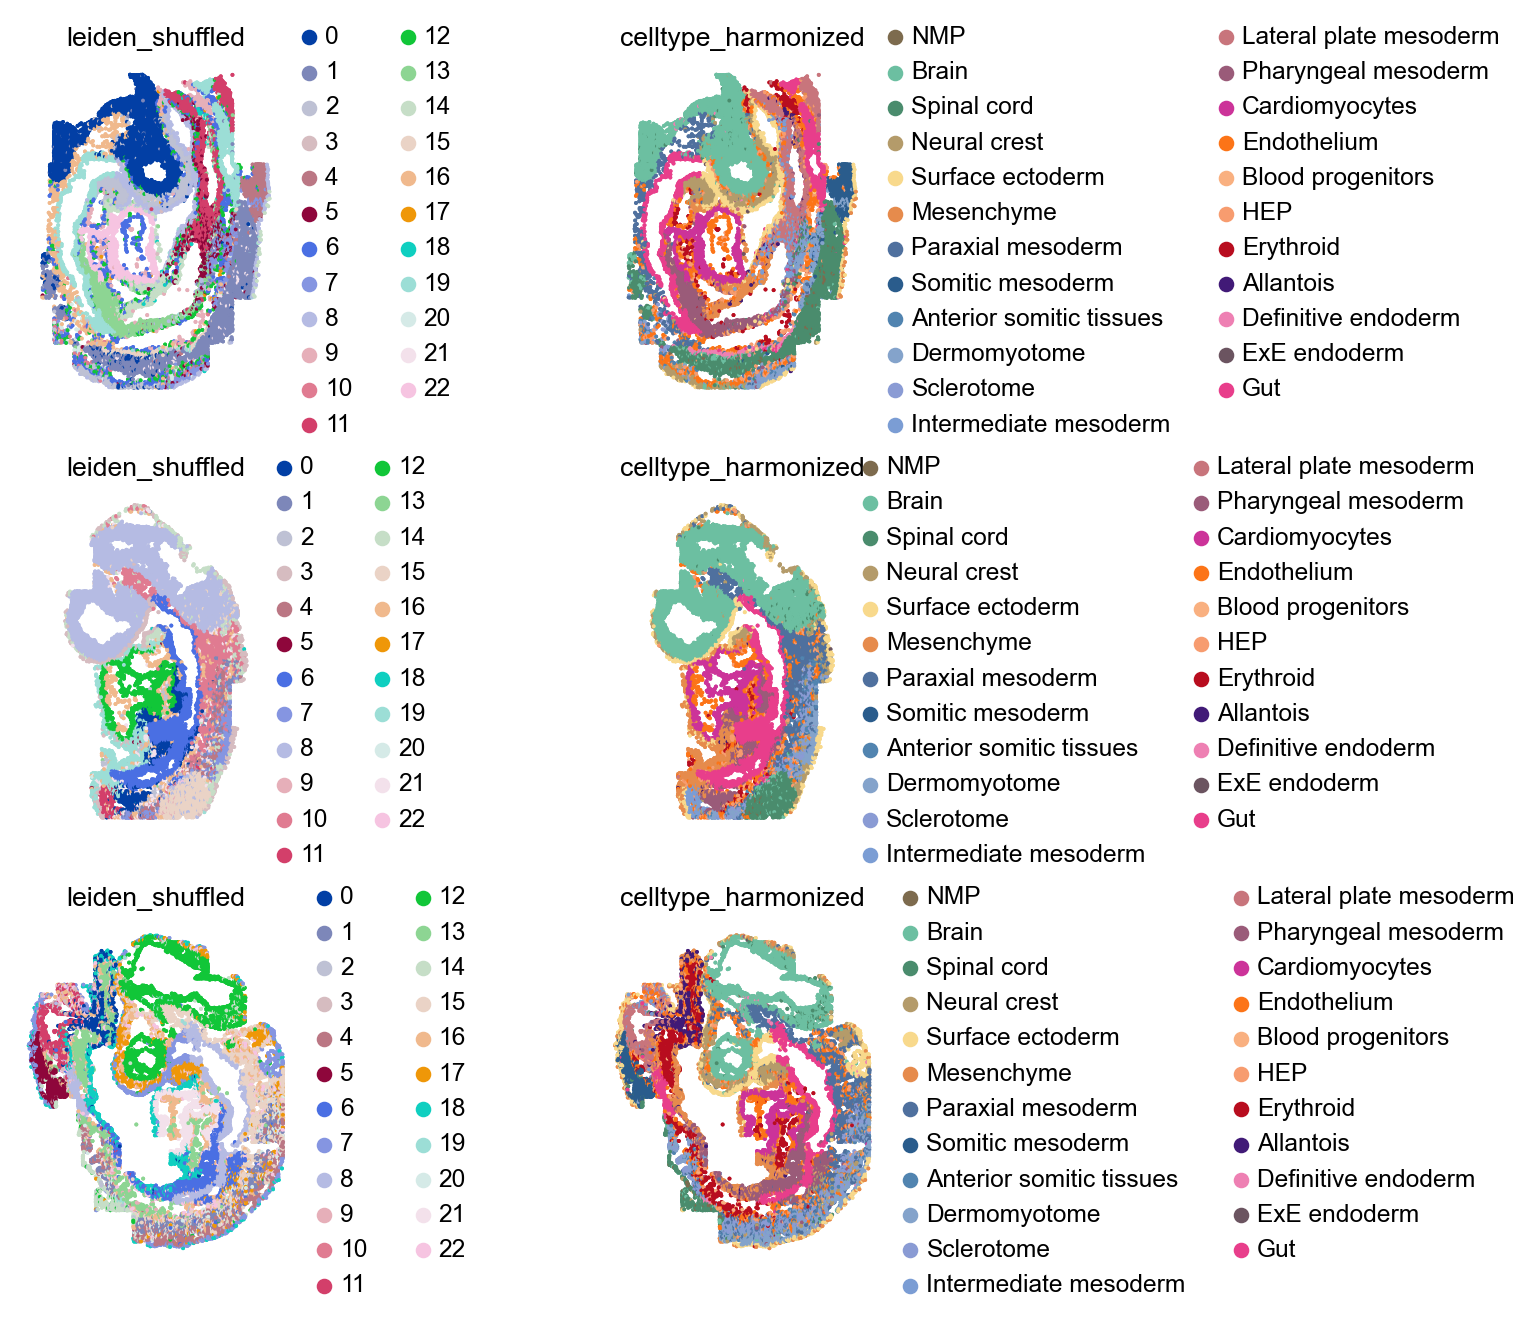

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sq.pl.spatial_scatter(
        adata,
        color=[
            "leiden_shuffled",
            "celltype_harmonized",
        ],
        library_key="embryo",
        shape=None,
        ncols=2,
        figsize=(4, 3),
        wspace=0.1,
    )

Let's also do some basic pre-processing of the counts. 

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Query cell type labels per sample

In [13]:
ca_sp = CellAnnotator(
    adata,
    species="mouse",
    tissue="everything/organogenesis",
    stage="embryonic day 8.5",
    cluster_key="leiden_shuffled",
    sample_key="embryo",
    model="gemini-2.5-flash",
)
ca_sp

INFO     ✅ GEMINI API key is available                                                                            
INFO     Initializing `3` SampleAnnotator objects(s).                                                              


🧬 CellAnnotator
📋 Species: mouse
🔬 Tissue: everything/organogenesis
⏳ Stage: embryonic day 8.5
🔗 Cluster key: leiden_shuffled
🔬 Sample key: embryo

🤖 Provider: gemini
🧠 Model: gemini-2.5-flash

🔋 Status: ✅ Ready

📊 Samples: 3
🏷️  Sample IDs: 'embryo1', 'embryo2', 'embryo3'

Let's first query expected cell types and marker genes in this system. 

In [14]:
ca_sp.get_expected_cell_type_markers()

INFO     Querying cell types.                                                                                      
INFO     Writing expected cell types to `self.expected_cell_types`                                                 
INFO     Querying cell type markers.                                                                               
INFO     Writing expected marker genes to `self.expected_marker_genes`.                                            
INFO     Filtering marker genes to only include those present in adata.var_names.                                  


With that, we can run the annotation workflow. 

In [15]:
ca_sp.get_cluster_markers(min_auc=0.6, min_specificity=0.6)

INFO     Iterating over samples to compute cluster marker genes.                                                   


  0%|          | 0/3 [00:00<?, ?it/s]

WARNING  Not enough cells for cluster 17 in sample `embryo2` (1<3).                                                


In [16]:
ca_sp.annotate_clusters()

INFO     Iterating over samples to annotate clusters.                                                              


  0%|          | 0/3 [00:00<?, ?it/s]

WARNING  Not enough markers provided for cluster 3 in sample `embryo1` (1<2).                                      
WARNING  Not enough markers provided for cluster 10 in sample `embryo3` (0<2).                                     
INFO     Querying cell-type label de-duplication.                                                                  
INFO     Removed 8/29 cell types.                                                                                  
INFO     Iterating over samples to harmonize cell type annotations.                                                


  0%|          | 0/3 [00:00<?, ?it/s]

INFO     Writing updated cluster labels to `adata.obs[`cell_type_predicted'].                                      


🧬 CellAnnotator
📋 Species: mouse
🔬 Tissue: everything/organogenesis
⏳ Stage: embryonic day 8.5
🔗 Cluster key: leiden_shuffled
🔬 Sample key: embryo

🤖 Provider: gemini
🧠 Model: gemini-2.5-flash

🔋 Status: ✅ Ready

📊 Samples: 3
🏷️  Sample IDs: 'embryo1', 'embryo2', 'embryo3'

In [17]:
ca_sp.reorder_and_color_clusters(keys=["celltype_harmonized", "cell_type_predicted"], assign_colors=True)

INFO     Querying label ordering.                                                                                  
INFO     Querying cluster colors.                                                                                  
INFO     Writing categories for key 'celltype_harmonized'                                                          
INFO     Writing categories for key 'cell_type_predicted'                                                          


Compute ground-truth with predicted cell type labels in a confusion matrix (across all samples). 

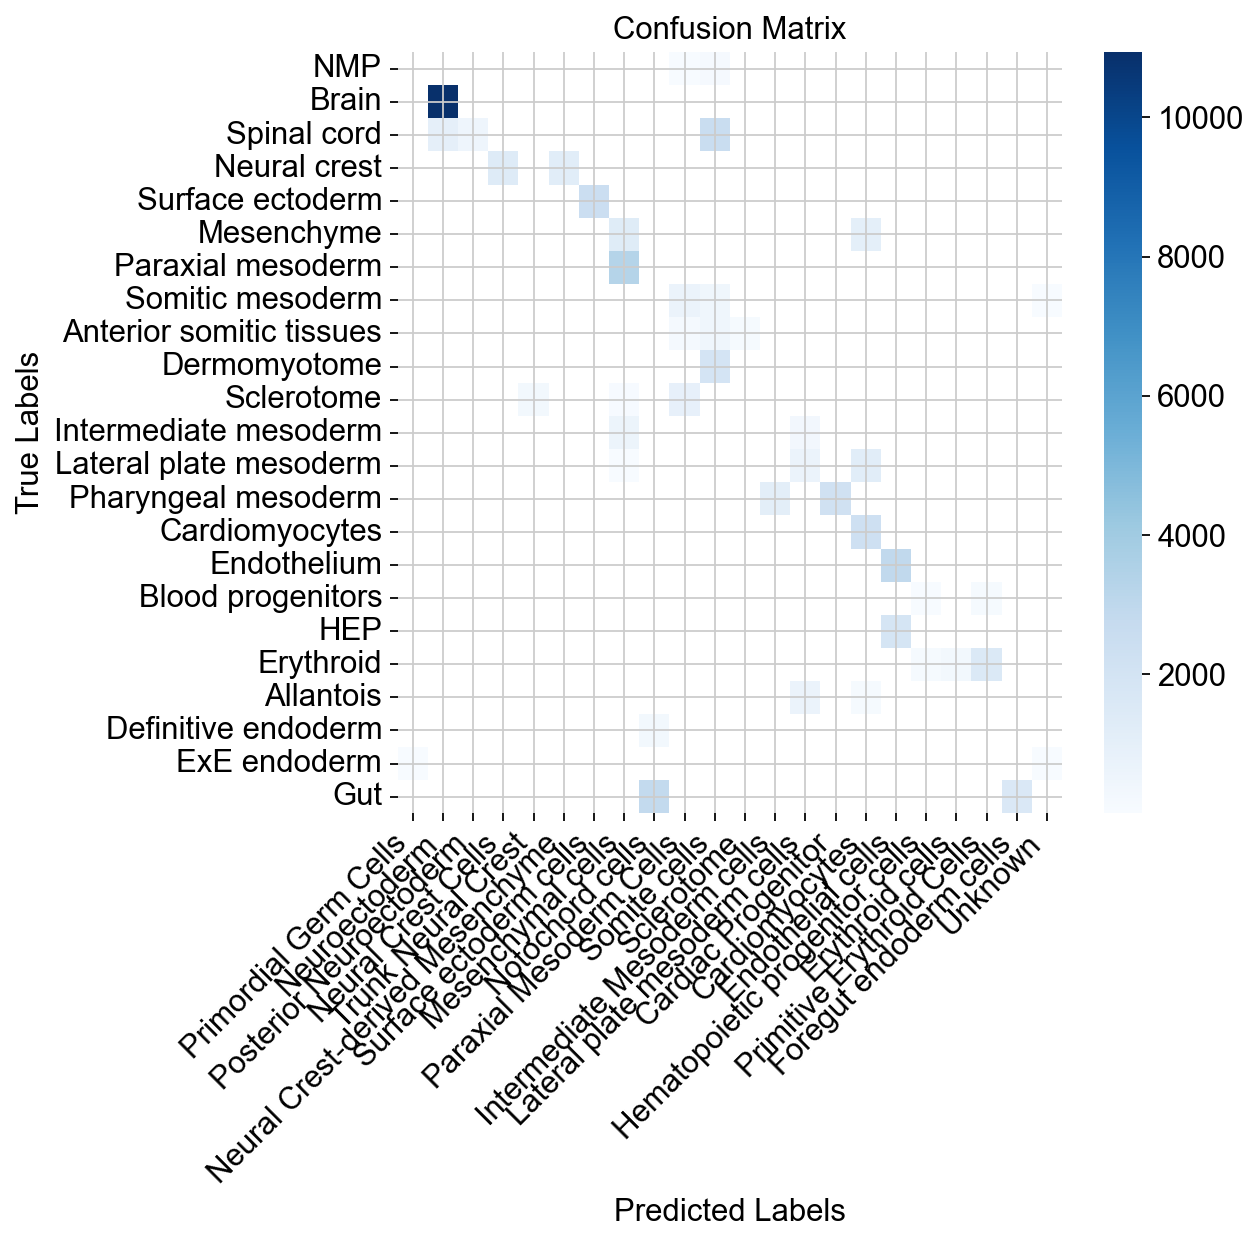

In [18]:
df = adata.obs.groupby(["celltype_harmonized", "cell_type_predicted"], observed=True).size().unstack()

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(df, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We can also inspect results in spatial coordinates. Note that we changed the colors of the original annotations to easy comparisons with the predictions. 

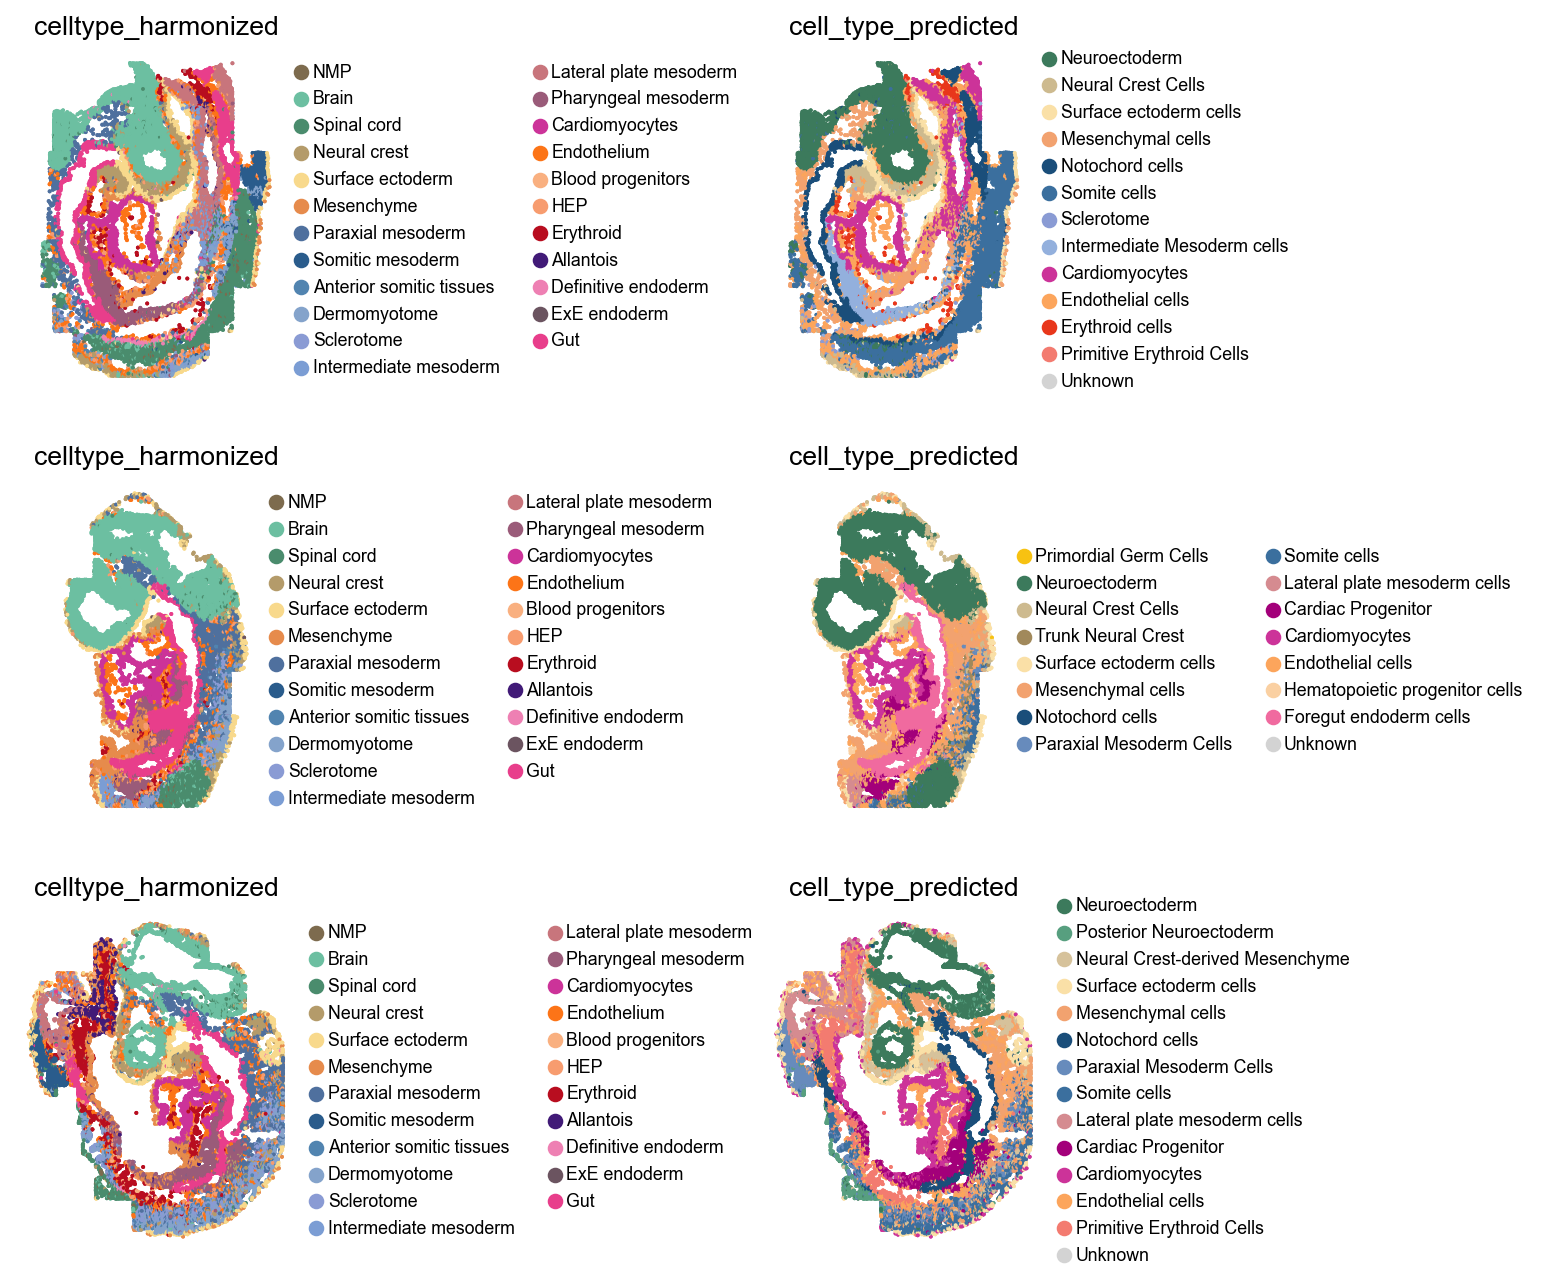

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    with plt.rc_context({"legend.fontsize": 8}):
        sq.pl.spatial_scatter(
            adata,
            color=[
                "celltype_harmonized",
                "cell_type_predicted",
            ],
            library_key="embryo",
            shape=None,
            ncols=2,
            wspace=0.3,
            figsize=(4, 3),
        )